In [88]:
!git clone https://github.com/AmauryTavares/ReconhecimentoCAPTCHA.git

fatal: destination path 'ReconhecimentoCAPTCHA' already exists and is not an empty directory.


## Reconhecimento de CAPTCHA


###  Comece importando os pacotes necessários para o projeto

In [0]:
import cv2 as cv
import numpy as np
import os
import keras
import csv
from zipfile import ZipFile
from PIL import Image
from IPython.display import Image

from keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint   

In [0]:
def getSegments(sorted_contours, binary_openning):
    rois = []
    img_segmented = cv.cvtColor(binary_openning, cv.COLOR_GRAY2BGR)
    for i, ctr in enumerate(sorted_contours):
        # obtem pontos inicial, altura e largura do retangulo
        x, y, w, h = cv.boundingRect(ctr)

        # obtem parte segmentada
        roi = binary_openning[y:y + h, x:x + w]
        rois.append(roi)

        # mostra parte segmentada
        cv.rectangle(img_segmented, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return rois, img_segmented
  
def averageROI(rois):
    average = 0;
    for roi in rois:
        average += roi.shape[1]

    average = (average/len(rois)) * 1.2
    return average
  
#remove outliers de segmentos de ruidos menores
def removeMinimumOutliersROI(rois):
    newRois = []
    for roi in rois:
        if roi.shape[0] * roi.shape[1] > 800:
            newRois.append(roi)

    return newRois

#remove outliers de segmentos de ruidos maiores
def removeAvarageOutliersROI(rois):
    averagePixels = 0
    newRois = []
    for roi in rois:
        averagePixels += roi.shape[0] * roi.shape[1]

    averagePixels = (averagePixels/len(rois)) * 0.7

    for roi in rois:
        if roi.shape[0] * roi.shape[1] >= averagePixels:
            newRois.append(roi)

    return newRois

#segmenta os rois maiores
def separateSegment(rois):
    newRois = []
    average = np.int32(averageROI(rois))

    for roi in rois:
        sizeBigger = np.int32(roi.shape[1]/average)

        if sizeBigger == 0:
            newRois.append(roi)
        else:
            sizeBigger += 1
            width = np.int32(roi.shape[1]/sizeBigger)
            height = roi.shape[0]
            y = 0
            x = 0
            for i in range(sizeBigger):
                newRois.append(roi[y:height, x:width * (i + 1)])
                x += width

    return newRois

In [0]:
def preProcessing(path):
    # Mascara para usada na operacao morfologica
    kernel = np.ones((4, 4), np.int8)

    #carreg imagem original
    src = cv.imread(path, cv.IMREAD_GRAYSCALE)

    # converte imagem para tom de cinza
    src_gray = cv.imread(path, cv.IMREAD_GRAYSCALE)

    # binarizacao da imagem
    ret, binary = cv.threshold(src_gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    # operacao morfologica de fechamento
    binary_openning = cv.morphologyEx(binary, cv.MORPH_CLOSE, kernel)

    # imagem negativa
    binary_negative = cv.bitwise_not(binary_openning)

    # obtem os contornos do captcha
    _, contours, _ = cv.findContours(binary_negative, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # ordena os contornos no eixo x
    sorted_contours = sorted(contours, key=lambda ctr: cv.boundingRect(ctr)[0])

    rois, img_segmented = getSegments(sorted_contours, binary_openning)
    if len(rois) > 1:
        rois = removeMinimumOutliersROI(rois)
        rois = separateSegment(rois)
        rois = removeAvarageOutliersROI(rois)

    # modifica o tamanho para 28x28
    for i, roi in enumerate(rois):
      rois[i] = cv.resize(roi, (28,28), interpolation=cv.INTER_AREA)
        
    return rois, src

# def runDatabase(path):
#     for _,_,files in os.walk(path):
#         for filename in files:
#             preProcessing(path + filename)

# runDatabase('./images/')

### 4.  Dividir base de dados em conjuntos de treinamento, teste e validação.

In [0]:
# Carregar base de dados
#display(Image('2a4f.png'))
def loadDatabase():
  files = []
  filenames = []
  root = './ReconhecimentoCAPTCHA/images/'
  # carregar nomes dos captchas
  with open('./ReconhecimentoCAPTCHA/filenames.csv', 'r') as readFile:
    reader = csv.reader(readFile)
    filenames = list(reader)[0]

  for filename in filenames:
    files.append(root + filename)
   
  # divide base de dados
  training_data, validation_data, test_data = files[:6000], files[6000:10000], files[10000:]
  training_label, validation_label, test_label = filenames[:6000], filenames[6000:10000], filenames[10000:]
    
  print(len(training_data), 'exemplos de treino')
  print(len(validation_data), 'exemplos de validação')
  print(len(test_data), 'exemplos de teste')
    
  return (training_data, validation_data, test_data, training_label, validation_label, test_label)

In [0]:
# Faz o mapeamento de caracter para one hot
def mapAlphanumeticToOnehot(caracter):
  alphanumeric = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                  'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
                  'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
                  'u', 'v', 'x', 'y', 'z', 'w']
  
  for x, _ in enumerate(alphanumeric):
    if caracter == alphanumeric[x]:
      alphanumeric[x] = 1
    else:
      alphanumeric[x] = 0
  
  return alphanumeric

def convertToOnehot(label):
  newLabel = np.zeros((len(label), 36))
  for i, x in enumerate(label):
    newLabel[i, :] = mapAlphanumeticToOnehot(x)
  return newLabel


def expandDatabase(x_train, y_train):
  rois_x_train = np.zeros((4*(len(x_train)), 28, 28, 1))
  rois_y_train = []
  i = 0
  
  for x, y in zip(x_train, y_train):
    rois, _ = preProcessing(x)

    for roi in rois:
      roi = roi.astype('float32')/255
      rois_x_train[i, :, :, :] = roi.reshape((28,28,1))
      i += 1

    filename = y.split('.')[0]
    
    for x in filename:
      rois_y_train.append(x)
      
  print('Pre-processamento concluído!')
    
  return rois_x_train, rois_y_train

### 5. Construa o modelo Lenet

In [0]:
def build_LeNet(width, height, depth, classes):
  # initialize the model
  model = Sequential()
  inputShape = (height, width, depth)

  # first set of CONV => RELU => POOL layers
  model.add(Conv2D(20, (5, 5), padding="same",
    input_shape=inputShape))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  # second set of CONV => RELU => POOL layers
  model.add(Conv2D(50, (5, 5), padding="same"))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  # first (and only) set of FC => RELU layers
  model.add(Flatten())
  model.add(Dense(500))
  model.add(Activation("relu"))

  # softmax classifier
  model.add(Dense(classes))
  model.add(Activation("softmax"))
  
  model.summary()
  
  # return the constructed network architecture
  return model

### 6. Construa o modelo MiniVGG

In [0]:
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout

def build_MiniVGG(width, height, depth, classes):
  # initialize the model
  model = Sequential()
  inputShape = (height, width, depth)# first CONV => RELU => CONV => RELU => POOL layer set
  model.add(Conv2D(32, (3, 3), padding="same",
  input_shape=inputShape))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  # second CONV => RELU => CONV => RELU => POOL layer set
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  # first (and only) set of FC => RELU layers
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  
  # softmax classifier
  model.add(Dense(classes))
  model.add(Activation("softmax"))
  
  model.summary()
  
  # return the constructed network architecture
  return model
  

### 7. Compile o modelo desejado (Lenet ou MiniVGG)

In [108]:
opt = SGD(lr=0.01)
model = build_LeNet(width=28, height=28, depth=1, classes=36)
model.compile(loss='categorical_crossentropy', optimizer=opt, 
                  metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 28, 28, 20)        520       
_________________________________________________________________
activation_31 (Activation)   (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_32 (Activation)   (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2450)              0         
__________

### 8. Treine o Modelo

In [109]:
# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

(x_train, x_valid, _, y_train, y_valid, _) = loadDatabase()

x_train, y_train = expandDatabase(x_train, y_train)
x_valid, y_valid = expandDatabase(x_valid, y_valid)
y_train = convertToOnehot(y_train)
y_valid = convertToOnehot(y_valid)

hist = model.fit(x_train, y_train, batch_size=128, epochs=20,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=2, shuffle=True)

6000 exemplos de treino
4000 exemplos de validação
5055 exemplos de teste
Pre-processamento concluído!
Pre-processamento concluído!
Train on 24000 samples, validate on 16000 samples
Epoch 1/20
 - 3s - loss: 1.8143 - acc: 0.5479 - val_loss: 0.6336 - val_acc: 0.8563

Epoch 00001: val_loss improved from inf to 0.63357, saving model to model.weights.best.hdf5
Epoch 2/20
 - 1s - loss: 0.4504 - acc: 0.9017 - val_loss: 0.3919 - val_acc: 0.9133

Epoch 00002: val_loss improved from 0.63357 to 0.39190, saving model to model.weights.best.hdf5
Epoch 3/20
 - 1s - loss: 0.3423 - acc: 0.9278 - val_loss: 0.3169 - val_acc: 0.9317

Epoch 00003: val_loss improved from 0.39190 to 0.31685, saving model to model.weights.best.hdf5
Epoch 4/20
 - 1s - loss: 0.2967 - acc: 0.9380 - val_loss: 0.3064 - val_acc: 0.9329

Epoch 00004: val_loss improved from 0.31685 to 0.30644, saving model to model.weights.best.hdf5
Epoch 5/20
 - 1s - loss: 0.2651 - acc: 0.9467 - val_loss: 0.2849 - val_acc: 0.9409

Epoch 00005: val_l

### 9. Carrege o modelo com a melhor acurácia no conjunto de validação

In [0]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.best.hdf5')

### **10**. Calcule a acurácia no conjunto de teste

In [111]:
# evaluate and print test accuracy
(_, _, x_test, _, _, y_test) = loadDatabase()
length_test = len(x_test)
x_test, y_test = expandDatabase(x_test, y_test)
y_test = convertToOnehot(y_test)

score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Taxa de acerto:', score[1])

6000 exemplos de treino
4000 exemplos de validação
5055 exemplos de teste
Pre-processamento concluído!

 Taxa de acerto: 0.9451533135391484


### **11**.  Calculando acurácia

In [112]:
predictions = model.predict(x_test, batch_size=4)
result = predictions.argmax(axis=1)
result_test = y_test.argmax(axis=1)

totalHit = 0
onlyOneMiss = 0

for i in range(length_test):
  hit = 0
  for x in range(i*4, (i+1)*4):
    if (result[x] == result_test[x]):
      hit += 1
  
  if hit == 4:
    totalHit += 1
    onlyOneMiss += 1
  elif hit == 3:
    onlyOneMiss += 1
  
print('Taxa de acerto (4 caracteres):', totalHit / length_test)
print('Taxa de acerto (3 caracteres):', onlyOneMiss / length_test)

Taxa de acerto (4 caracteres): 0.8405539070227498
Taxa de acerto (3 caracteres): 0.9661721068249258


### **11**. Informações sobre acurácia no treinamento

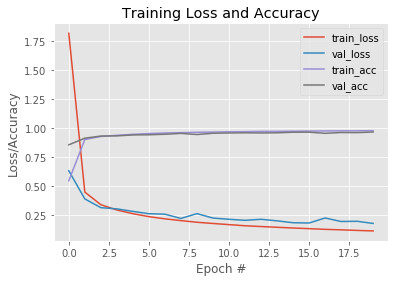

In [113]:
# # evaluate the network
# print("[INFO] evaluating network...")

# # get predictions on the test set
# predictions = model.predict(x_test, batch_size=128)

# # define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
# cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# print(classification_report(y_test.argmax(axis=1),
# predictions.argmax(axis=1),
# target_names=cifar10_labels))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), hist.history["loss"], label="train_loss" )
plt.plot(np.arange(0, 20), hist.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), hist.history["acc" ], label="train_acc" )
plt.plot(np.arange(0, 20), hist.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()